<a href="https://colab.research.google.com/github/danielarruda1000/machine_learn_previsao_letalidade_rj/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TCC**

**Título do Trabalho**:
Machine Learn: Modelo de previsão de taxa de letalidade violenta no estado do Rio de
Janeiro

**Resumo**: O trabalho visa aplicar 4 modelos estatísticos e comparar as metodologias e desempenho de cada um para prever a taxa de letalidade violenta no estado do Rio de Janeiro por 100 mil habitantes. Os modelos aplicados para esse trabalho, são eles: Arima(1,0,0), ARIMA(1,1,0), ARIMA(0,1,1) e ARIMA(2,1,0)

Nome: Daniel Nascimento Arruda |
Email: danielarruda1000@gmail.com | 
Whatsapp: 21984088497

#### Importando bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set(rc={'figure.figsize':(10,5)})
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/
%cd TCC

Mounted at /gdrive
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/TCC


#### Lendo os dados

In [38]:
df = pd.read_csv('BaseEstadoTaxaMes.csv', sep=';')
df = df[['ano','mes','mes_ano','letalidade_violenta']].rename(columns={'ano':'year','mes':"month"})
df['data'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['letalidade_violenta'] = df['letalidade_violenta'].str.replace(',','.').astype(float)
df = df[(df['data'] >= pd.to_datetime('2005-01-01')) & (df['data'] < pd.to_datetime('2022-01-01'))] # Dados a partir de 2005

In [39]:
df

,year,month,mes_ano,letalidade_violenta,data
24,2005,1,2005m01,4.67,2005-01-01
25,2005,2,2005m02,4.60,2005-02-01
26,2005,3,2005m03,5.32,2005-03-01
27,2005,4,2005m04,4.04,2005-04-01
28,2005,5,2005m05,4.49,2005-05-01
...,...,...,...,...,...
223,2021,8,2021m08,2.21,2021-08-01
224,2021,9,2021m09,2.05,2021-09-01
225,2021,10,2021m10,2.32,2021-10-01
226,2021,11,2021m11,1.86,2021-11-01


#### Analisando os dados

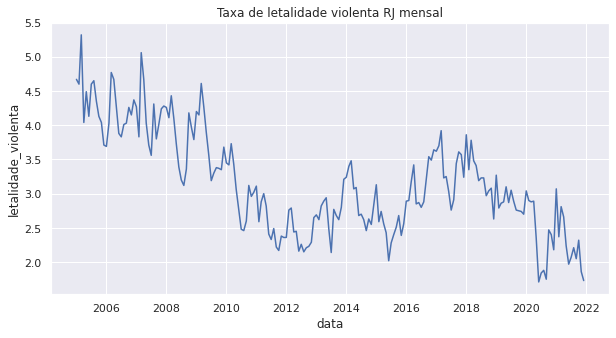

In [40]:
sns.lineplot(data=df, x='data', y='letalidade_violenta')
plt.title('Taxa de letalidade violenta RJ mensal')
plt.show()

		Decomposição da série temporal


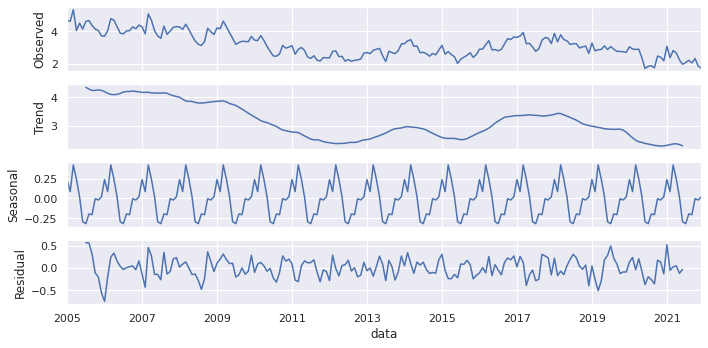

In [41]:
## Decomposição da série temporal
print('\t\tDecomposição da série temporal')
seasonal_decompose(df.set_index('data')['letalidade_violenta'], model='additive').plot()
plt.show()

ACF plot


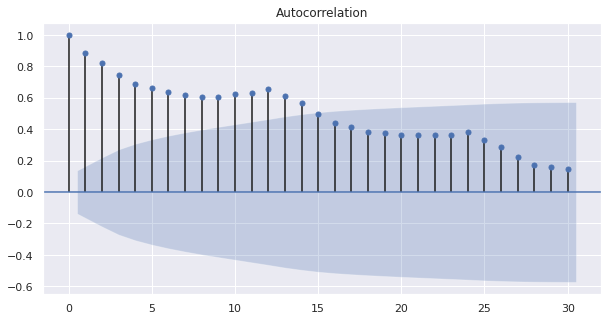

In [42]:
print('ACF plot')
plot_acf(df['letalidade_violenta'],lags=30)
plt.show()

PACF plot


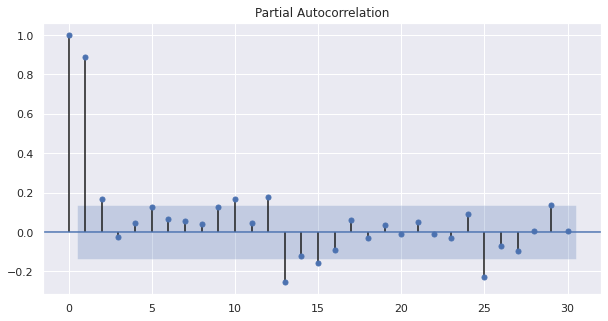

In [43]:
print('PACF plot')
plot_pacf(df['letalidade_violenta'],lags=30)
plt.show()

In [44]:
print('Estatísticas gerais:')
df['letalidade_violenta'].describe()

Estatísticas gerais:


count    204.000000
mean       3.158333
std        0.747854
min        1.710000
25%        2.620000
50%        3.045000
75%        3.702500
max        5.320000
Name: letalidade_violenta, dtype: float64

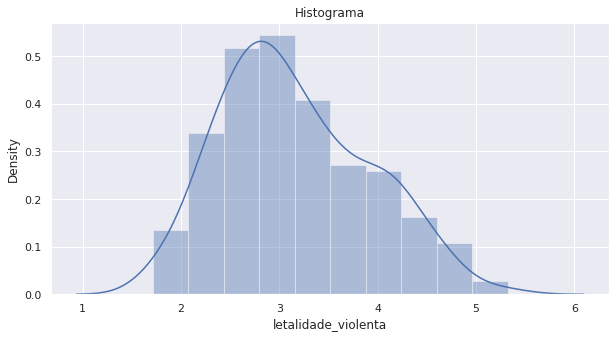

In [45]:
sns.distplot(df['letalidade_violenta'])
plt.title('Histograma')
plt.show()

In [46]:
# Teste de normalidade 
from scipy.stats import shapiro, normaltest

In [47]:
# Shapiro
stat, p = shapiro(df['letalidade_violenta'])
alpha = 0.05

print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
  print('The data looks Gaussian (Fail to reject null hypothesis)')
else:
  print('The data doe not look Gaussian (Reject H0) ')

Statistics=0.976, p=0.001
The data doe not look Gaussian (Reject H0) 


In [48]:
# D'Agostino's K^2

stat, p = normaltest(df['letalidade_violenta'])
alpha = 0.05

print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
  print('The data looks Gaussian (Fail to reject null hypothesis)')
else:
  print('The data doe not look Gaussian (Reject H0) ')

Statistics=8.639, p=0.013
The data doe not look Gaussian (Reject H0) 


In [49]:
# Transformação da série para normalizar
from scipy.stats import boxcox

In [50]:
df['letalidade_violenta_transformada'] = boxcox(df['letalidade_violenta'], 0)

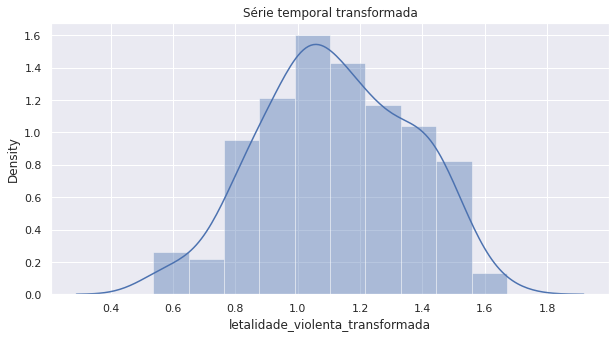

In [51]:
sns.distplot(df['letalidade_violenta_transformada'])
plt.title('Série temporal transformada')
plt.show()

In [77]:
# Teste de normalidade

# Shapiro
stat, p = shapiro(df['letalidade_violenta_transformada'])
alpha = 0.05

print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
  print('The data looks Gaussian (Fail to reject null hypothesis)')
else:
  print('The data doe not look Gaussian (Reject H0) ')

Statistics=0.990, p=0.146
The data looks Gaussian (Fail to reject null hypothesis)


In [78]:
# D'Agostino's K^2

stat, p = normaltest(df['letalidade_violenta_transformada'])
alpha = 0.05

print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
  print('The data looks Gaussian (Fail to reject null hypothesis)')
else:
  print('The data doe not look Gaussian (Reject H0) ')

Statistics=4.152, p=0.125
The data looks Gaussian (Fail to reject null hypothesis)


### Aplicando os modelos 

#### ARIMA

### Vamos usar 1° ordem de diferenciação por estar mais estatisticamente estácionária a série

In [79]:
# Gerando a série estacionaria com a tecnica de diferenciação (Y' em t = Y em t - Y em t-1)
df['y_linha'] = df['letalidade_violenta_transformada'].diff()
df['y_linha_diff_2'] = ((df['letalidade_violenta_transformada'] - df['letalidade_violenta_transformada'].shift(1)) -
                        (df['letalidade_violenta_transformada'].shift(1) - df['letalidade_violenta_transformada'].shift(2)))

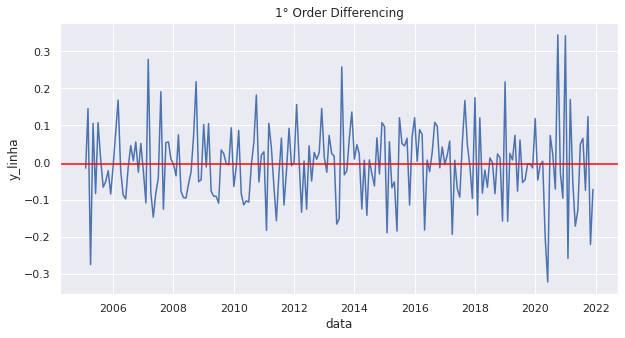

ADF Statistic: -4.711381196005209
p-value: 8.010618676682394e-05
Critical Values:
	1%: -3.465058702600837
	5%: -2.8767942675230356
	10%: -2.5749014492475535


In [80]:
sns.lineplot(data=df, x='data', y='y_linha')
plt.title('1° Order Differencing')
plt.axhline(df['y_linha'].mean(), color='red')
plt.show()

# Teste para ver se a série é estacionária
result = adfuller(df['y_linha'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

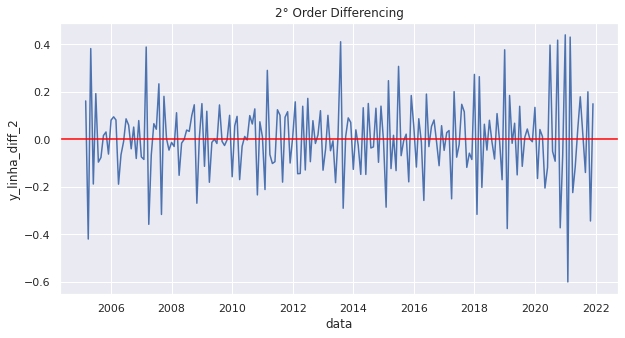

ADF Statistic: -9.705760738367848
p-value: 1.0429895654909519e-16
Critical Values:
	1%: -3.4654311561944873
	5%: -2.8769570530458792
	10%: -2.574988319755886


In [81]:
sns.lineplot(data=df, x='data', y='y_linha_diff_2')
plt.title('2° Order Differencing')
plt.axhline(df['y_linha_diff_2'].mean(), color='red')
plt.show()

# Teste para ver se a série é estacionária
result = adfuller(df['y_linha_diff_2'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

#### Identificando os termos AR e MA do ARIMA através do ACF e PACF plot

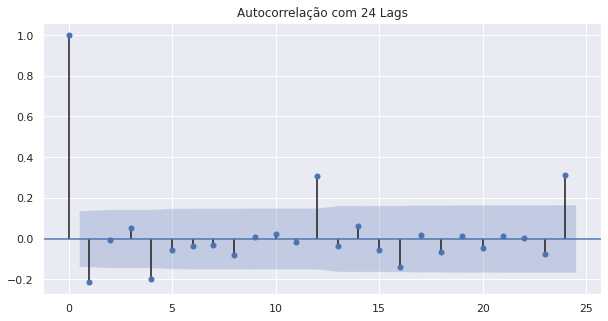

In [82]:
plot_acf(df['y_linha'].dropna(),lags=24)
plt.title('Autocorrelação com 24 Lags')
plt.show()

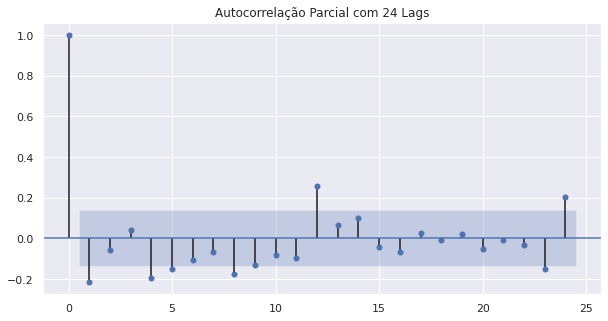

In [83]:
plot_pacf(df['y_linha'].dropna(),lags=24)
plt.title('Autocorrelação Parcial com 24 Lags')
plt.show()

#### Ajustando o modelo ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.letalidade_violenta   No. Observations:                  215
Model:                    ARIMA(2, 1, 2)   Log Likelihood                 -50.291
Method:                          css-mle   S.D. of innovations              0.305
Date:                   Sat, 02 Apr 2022   AIC                            112.582
Time:                           13:45:28   BIC                            132.806
Sample:                                1   HQIC                           120.754
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0114      0.007     -1.662      0.098      -0.025       0.002
ar.L1.D.letalidade_violenta    -0.4289      0.094     -4

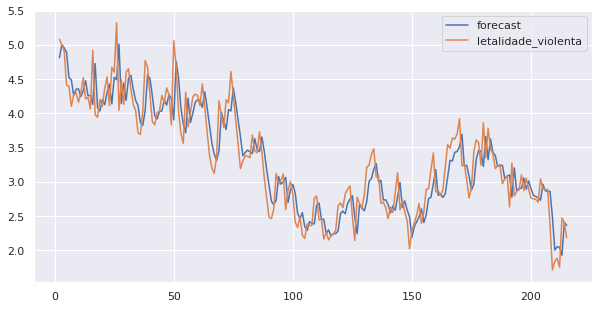

In [ ]:
# Separando dados de treino e teste
train = df['letalidade_violenta'].dropna()[:216]
test = df['letalidade_violenta'].dropna()[216:]

# Ajustando o modelo
arima_model = ARIMA(train, order=(2,1,2))
model = arima_model.fit()
print(model.summary())
model.plot_predict(dynamic=False)
plt.show()

#### Performance do modelo

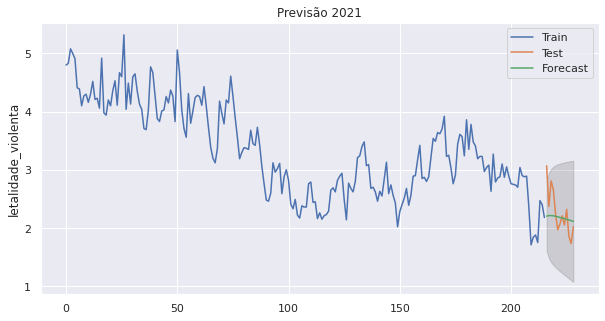

Performance do modelo
----------------------
MAPE: 11.41%
MPE: -1.5%
MAE: 0.27
RMSE: 0.36
CORR: 0.7

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 29.38
Taxa em 2021 prevista 28.27

Media mensal real: 2.26
Media mensal prevista 2.17


In [ ]:
# Output do modelo para 2021
fc, se, conf = model.forecast(13, alpha=0.05)

fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

# Plot
sns.lineplot(data=train, label='Train')
sns.lineplot(data=test, label='Test')
sns.lineplot(data=fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Previsão 2021')
plt.show()

# Performance
print('Performance do modelo')
print('----------------------')
mape = np.mean(np.abs(fc_series - test)/ np.abs(test))
mpe = np.mean((fc_series - test)/(test))
mae = np.mean(np.abs(fc_series - test))
rmse = np.mean((fc_series - test)**2)**.5
corr = np.corrcoef(fc_series, test)[0,1]

print(f'MAPE: {round(mape*100,2)}%')
print(f'MPE: {round(mpe*100,2)}%')
print(f'MAE: {round(mae,2)}')
print(f'RMSE: {round(rmse, 2)}')
print(f'CORR: {round(corr, 2)}')

print('\n Taxa de letalidade 2021')
print('---------------------------')
print('Taxa em 2021 real:', test.sum())
print('Taxa em 2021 prevista', round(fc_series.sum(), 2))
print('\nMedia mensal real:', round(test.mean(),2))
print('Media mensal prevista', round(fc_series.mean(), 2))

# Modelos de previsão

In [75]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score

def run_arima_model(p,d,q, serie):

  print(f'RODANDO ARIMA({p},{d},{q})')

  # Separando dados de treino e teste
  train = serie.dropna()[:192]
  test = serie.dropna()[192:]

  # Ajustando o modelo
  arima_model = ARIMA(train, order=(p,d,q))
  model = arima_model.fit()
  print(model.summary())
  model.plot_predict(dynamic=False)
  plt.show()

  print('\n\nPERFORMANCE')

  # Output do modelo para 2021
  fc, se, conf = model.forecast(12, alpha=0.05)

  fc_series = pd.Series(fc, index = test.index)
  lower_series = pd.Series(conf[:, 0], index = test.index)
  upper_series = pd.Series(conf[:, 1], index = test.index)

  # Plot
  sns.lineplot(data=train, label='Train')
  sns.lineplot(data=test, label='Test')
  sns.lineplot(data=fc_series, label='Forecast')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
  plt.title('Previsão 2021')
  plt.show()

  # Performance
  print('Performance do modelo')
  print('----------------------')

  

  mape = np.mean(np.abs(test - fc_series)/ np.abs(test))
  rmse = np.mean((test - fc_series)**2)**.5
  r2 = r2_score(test, fc_series)

  print(f'MAPE: {round(mape*100,2)}%')
  print(f'RMSE: {round(rmse, 2)}')
  print(f'R2: {r2}')

  print('\n Taxa de letalidade 2021')
  print('---------------------------')
  print('Taxa em 2021 real:', test.sum())
  print('Taxa em 2021 prevista', round(fc_series.sum(), 2))
  print('\nMedia mensal real:', round(test.mean(),2))
  print('Media mensal prevista', round(fc_series.mean(), 2))

## ARIMA (1,0,0)

RODANDO ARIMA(1,0,0)
                                     ARMA Model Results                                     
Dep. Variable:     letalidade_violenta_transformada   No. Observations:                  192
Model:                                   ARMA(1, 0)   Log Likelihood                 175.045
Method:                                     css-mle   S.D. of innovations              0.097
Date:                              Mon, 23 May 2022   AIC                           -344.090
Time:                                      20:49:06   BIC                           -334.317
Sample:                                           0   HQIC                          -340.132
                                                                                            
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                

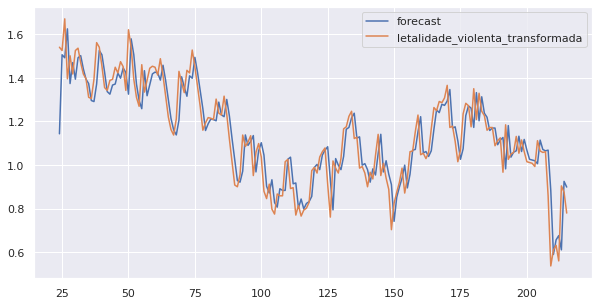



PERFORMANCE


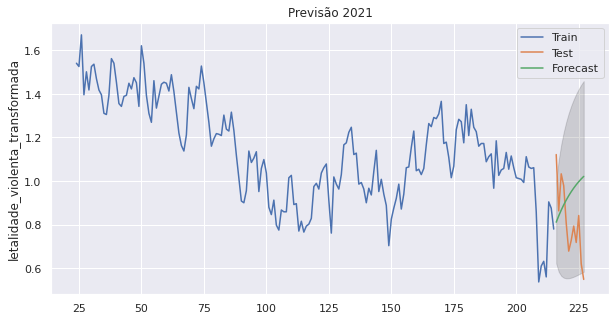

Performance do modelo
----------------------
MAPE: 30.28%
RMSE: 0.25
R2: -1.3968371709141039

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 11.18

Media mensal real: 0.81
Media mensal prevista 0.93


In [84]:
run_arima_model(1,0,0, df['letalidade_violenta_transformada'])

## ARIMA (1,1,0)

RODANDO ARIMA(1,1,0)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(1, 1, 0)   Log Likelihood                 173.793
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Mon, 23 May 2022   AIC                           -341.586
Time:                                        20:49:07   BIC                           -331.829
Sample:                                             1   HQIC                          -337.634
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

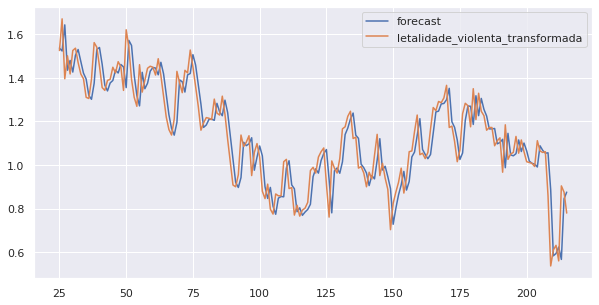



PERFORMANCE


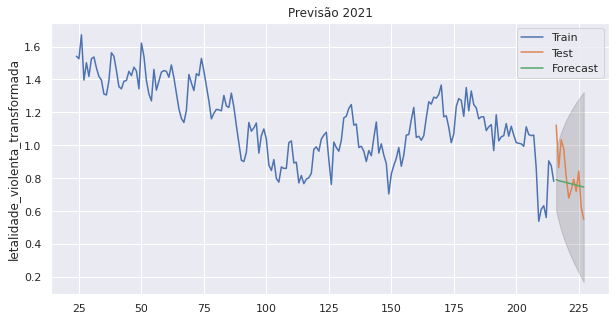

Performance do modelo
----------------------
MAPE: 15.26%
RMSE: 0.16
R2: 0.060581035151406115

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 9.2

Media mensal real: 0.81
Media mensal prevista 0.77


In [85]:
run_arima_model(1,1,0, df['letalidade_violenta_transformada'])

## ARIMA (0,1,1)

RODANDO ARIMA(0,1,1)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(0, 1, 1)   Log Likelihood                 174.130
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Mon, 23 May 2022   AIC                           -342.261
Time:                                        20:49:07   BIC                           -332.504
Sample:                                             1   HQIC                          -338.309
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

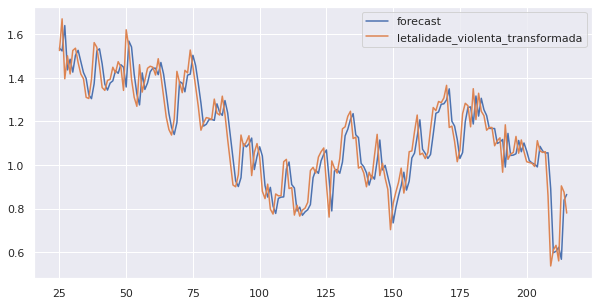



PERFORMANCE


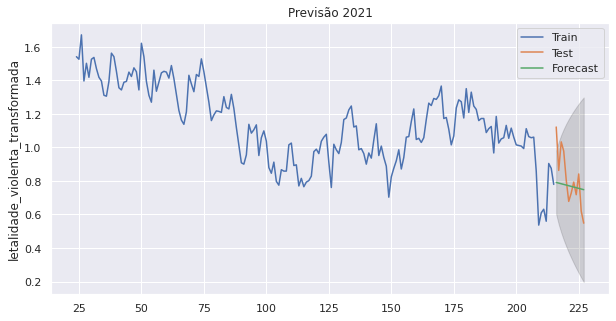

Performance do modelo
----------------------
MAPE: 15.27%
RMSE: 0.16
R2: 0.06612401556880543

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 9.23

Media mensal real: 0.81
Media mensal prevista 0.77


In [86]:
run_arima_model(0,1,1, df['letalidade_violenta_transformada'])

## ARIMA (2,1,0)

RODANDO ARIMA(2,1,0)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(2, 1, 0)   Log Likelihood                 174.239
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Mon, 23 May 2022   AIC                           -340.477
Time:                                        20:53:31   BIC                           -327.468
Sample:                                             1   HQIC                          -335.208
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

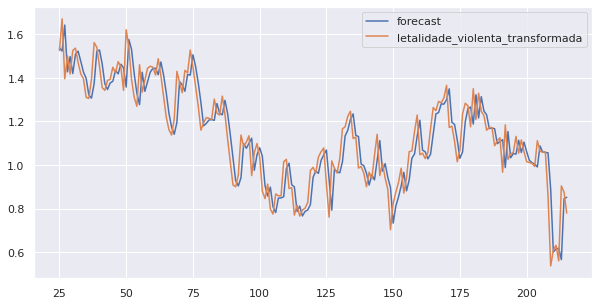



PERFORMANCE


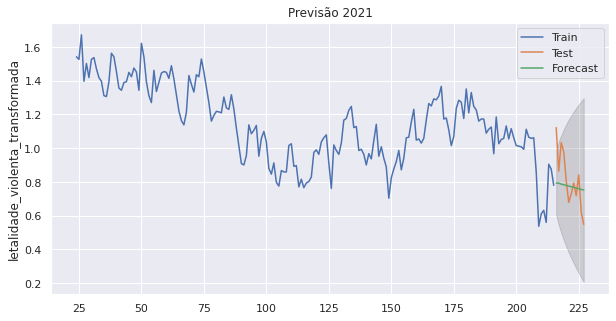

Performance do modelo
----------------------
MAPE: 15.27%
RMSE: 0.16
R2: 0.07341953823866076

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 9.28

Media mensal real: 0.81
Media mensal prevista 0.77


In [97]:
run_arima_model(2,1,0, df['letalidade_violenta_transformada'])

## ARIMA (2,1,2)

RODANDO ARIMA(2,1,2)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(2, 1, 2)   Log Likelihood                 179.599
Method:                                       css-mle   S.D. of innovations              0.094
Date:                                Mon, 23 May 2022   AIC                           -347.197
Time:                                        20:50:41   BIC                           -327.683
Sample:                                             1   HQIC                          -339.293
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

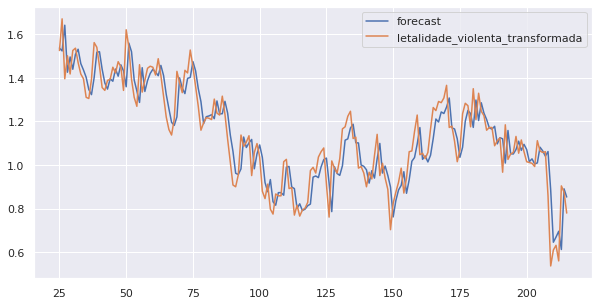



PERFORMANCE


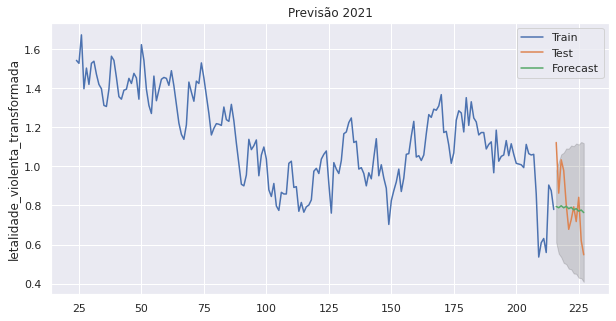

Performance do modelo
----------------------
MAPE: 15.79%
RMSE: 0.16
R2: 0.05445601360176422

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 9.41

Media mensal real: 0.81
Media mensal prevista 0.78


In [90]:
run_arima_model(2,1,2, df['letalidade_violenta_transformada'])

## ARIMA (3,1,0)

RODANDO ARIMA(3,1,0)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(3, 1, 0)   Log Likelihood                 174.248
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Mon, 23 May 2022   AIC                           -338.495
Time:                                        20:52:59   BIC                           -322.234
Sample:                                             1   HQIC                          -331.909
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

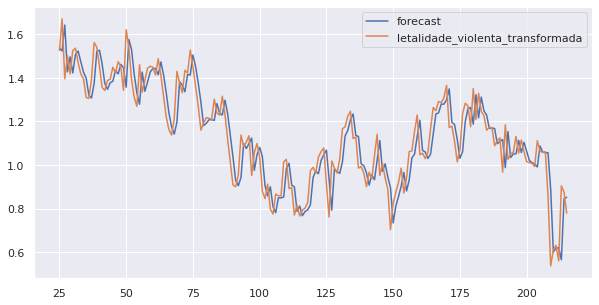



PERFORMANCE


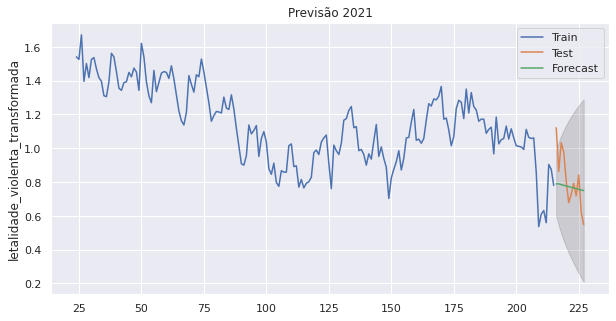

Performance do modelo
----------------------
MAPE: 15.28%
RMSE: 0.16
R2: 0.06487275937294179

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 9.729233529372527
Taxa em 2021 prevista 9.25

Media mensal real: 0.81
Media mensal prevista 0.77


In [95]:
run_arima_model(3,1,0, df['letalidade_violenta_transformada'])